In [ ]:
import numpy as np
import torch.nn
import json
import os

import matplotlib.pyplot as plt
import matplotlib.patches as patches


from PIL import Image

# Set default figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (30.0, 40.0)

%load_ext autoreload
%autoreload 2

In [2]:
# Set image and label directory
imgs_dir = "../cityscapes_dataset/cityscapes_samples"
labels_dir = "../cityscapes_dataset/cityscapes_samples_labels"

# Set accepted labels for this project
label_dict = {
    "person": 1,
    "persongroup": 2,
    "rider": 3,
    "bicycle": 4,
    "bicyclegroup": 5,
    "car": 6,
    "cargroup": 7,
    "bus": 8,
    "truck": 9,
    "traffic sign": 10,
    "traffic light": 11
}

In [3]:
from vehicle_detection.cityscape_datalist import *

# Create a data list of images
cs_data_list = CityScapeDatalist(imgs_dir, labels_dir, label_dict)
cs_data_list.prepare_data_list()

# Split data into train test and validation
cs_data_list.split_data()

1000 images processed


2000 images processed


3000 images processed


4000 images processed


5000 images processed


6000 images processed


7000 images processed


8000 images processed


9000 images processed


10000 images processed


11000 images processed


12000 images processed


13000 images processed


14000 images processed


15000 images processed


16000 images processed


17000 images processed


18000 images processed


19000 images processed


In [ ]:
train_list = np.load('train.npy')
valid_list = np.load('valid.npy')

In [ ]:
# TODO: Plot sample images
cs_data_list.data_list[0]


In [7]:
from vehicle_detection.cityscape_dataset import *
from vehicle_detection.solver import *

# Create a dataset using the data list you prepared
input_dim=(300, 300)
train_dataset = CityScapeDataset(cs_data_list.train_list, input_dim=input_dim, mode="train")
valid_dataset = CityScapeDataset(cs_data_list.valid_list, input_dim=input_dim, mode="test")

# Create a solver to train the model
solver = Solver(train_dataset, valid_dataset, batch_size=64)

In [7]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from vehicle_detection.bbox_helper import generate_prior_bboxes, loc2bbox, center2corner

# Draw bounding boxes on a sample from the data loader
mean_img = np.asarray((127, 127, 127), dtype=np.float32).reshape(3, 1, 1)
std_img = 128.0

with torch.no_grad():
    # Now I'm going to read a few data examples from the DataLoader and plot them
    idx, (x, gt_locs, gt_labels) = next(enumerate(solver.train_loader))
    
    print("Image shape is of shape: {}".format(x.shape))
    print("bbox_tensor is of shape {}".format(gt_locs.shape))
    print("bbox_label_tensor is of shape: {}".format(gt_labels.shape))

    NUM_IMGS = 2
    fig, ax = plt.subplots(NUM_IMGS)
    img_sample = x[:NUM_IMGS].clone()
    loc_sample = gt_locs[:NUM_IMGS, :, :].clone()
    prior_bboxes = generate_prior_bboxes()
    for i in range(1, NUM_IMGS + 1):
        img = np.asarray(img_sample[i - 1])
        img = (img * std_img) + mean_img
        img = np.ascontiguousarray(img.transpose(1, 2, 0).astype('uint8'))
        # Convert the locations to bbox
        bbox = loc2bbox(loc_sample[i - 1], prior_bboxes)
        # Convert bbox to corner format
        bbox = center2corner(bbox)
        bbox[:,[0,2]] *= input_dim[0]
        bbox[:,[1,3]] *= input_dim[1]
        # Draw bounding boxes on the image
        for k, (x, y, xw, yh) in enumerate(bbox):
            if gt_labels[i-1][k] in range(1,12):
                rect = patches.Rectangle([x,y], xw-x, yh-y, linewidth=1, edgecolor='r',
                                         facecolor='none')
                ax[i-1].add_patch(rect)
        ax[i-1].imshow(img)
    plt.show()

Image shape is of shape: torch.Size([64, 3, 300, 300])
bbox_tensor is of shape torch.Size([64, 2982, 4])
bbox_label_tensor is of shape: torch.Size([64, 2982])


In [8]:
from vehicle_detection.ssd_net import *
from vehicle_detection.bbox_loss import *

# Instantiate the model
num_classes = len(set(label_dict.values())) + 1

ssd_net = SSD(num_classes).cuda()

# Create an optimizer
optimizer = torch.optim.Adam(ssd_net.parameters(), lr=1e-3)

# Initialize loss function
loss_function = MultiboxLoss()

train_bbox_losses = []
train_class_losses = []

In [9]:
# Load the model if it exists
net_state = torch.load('vehicle_detection/ssd_net')
ssd_net.load_state_dict(net_state)

In [7]:
# Training the model
lr = 1e-3
for num_epochs in [5, 20, 20, 15, 5]:
# for num_epochs in [1]:
    optimizer.param_groups[0]['lr'] = lr
    tclass_loss, tbbox_loss, vclass_loss, vbbox_loss = solver.train(ssd_net, 
                                                                    optimizer, 
                                                                    loss_function,
                                                                    num_epochs=num_epochs,
                                                                    print_every=200)
    
    train_class_losses += tclass_loss
    train_bbox_losses += tbbox_loss
    lr *= 1e-1

This is epoch 0


Epoch 0, lr is 0.0010000, iteration 400 : total loss is 6.7228909, conf loss is 2.9401553, locs loss is 3.7827353


Validation: Accuracy = 3.794765937592784, total loss = 11.254822969436646, conf loss = 8.006637573242188, locs loss = 3.248185396194458


--------
This is epoch 1


In [17]:
# Save the model
net_state = ssd_net.state_dict()
torch.save(net_state, 'vehicle_detection/ssd_net')

In [10]:
# Generate prior boxes
prior_bboxes = generate_prior_bboxes()
train_loader = solver.train_loader
valid_loader = solver.valid_loader

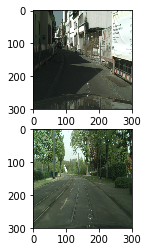

In [13]:
# Plotting sample bounding boxes
NUM_IMGS = 2
fig, ax = plt.subplots(NUM_IMGS)
mean_img = np.asarray((127, 127, 127), dtype=np.float32).reshape(3, 1, 1)
std_img = 128.0

with torch.no_grad():
    # Now I'm going to read a few data examples from the DataLoader and plot them
    ssd_net.eval()
    idx, (x, gt_locs, gt_labels) = next(enumerate(valid_loader))
    
    with torch.no_grad():
        # Move to the right device
        x = Variable(x.cuda())
        gt_locs = Variable(gt_locs.cuda())
        gt_labels = Variable(gt_labels.cuda())

        # Predict the classes and bbox coordinates for the input.
        confidences, locs = ssd_net.forward(x)

    img_sample = x[:NUM_IMGS].clone().cpu()
    loc_sample = locs[:NUM_IMGS, :, :].clone().cpu()
    conf_sample = confidences[:NUM_IMGS, :, :].clone().cpu()
    for i in range(0, NUM_IMGS):
        img = np.asarray(img_sample[i])
        img = (img * std_img) + mean_img
        img = np.ascontiguousarray(img.transpose(1, 2, 0).astype('uint8'))
        h, w, c = img.shape
        # Convert the locations to bbox
        bbox = loc2bbox(loc_sample[i], prior_bboxes)
        # Convert bbox to corner format
        bbox = center2corner(bbox)
        bbox[:, [0, 2]] *= w
        bbox[:, [1, 3]] *= h
        # Apply nms on the bounding boxes
        sel_boxes = nms_bbox(bbox, conf_sample[i])
        # Draw bounding boxes on the image
        for (bbox, label) in sel_boxes:
            (x, y, xw, yh) = bbox
            rect = patches.Rectangle([x, y], xw - x, yh - y, linewidth=1, edgecolor='r',
                                     facecolor='none')
            ax[i].add_patch(rect)
        ax[i].imshow(img)
    plt.show()


In [ ]:
from vehicle_detection.util.module_util import *
summary_layers(ssd_net.base_net, input_size=(3, 300, 300))

In [49]:
a = torch.randn(2, 2, 2)
b = torch.randn(1, 2, 2)
print(a)
print(b)
print(torch.min(a, b))

tensor([[[-0.2884, -1.3171],
         [ 0.9776,  0.4853]],

        [[-1.3066,  1.0038],
         [ 1.4060, -0.9773]]])
tensor([[[ 1.8054, -0.0292],
         [-0.3860, -1.1643]]])
tensor([[[-0.2884, -1.3171],
         [-0.3860, -1.1643]],

        [[-1.3066, -0.0292],
         [-0.3860, -1.1643]]])


In [51]:
a = a.permute(1, 0 ,2).contiguous()
b = b.permute(1, 0, 2).contiguous()
print(a)
print(b)
print(torch.min(a, b))

tensor([[[-0.2884, -1.3171],
         [-1.3066,  1.0038]],

        [[ 0.9776,  0.4853],
         [ 1.4060, -0.9773]]])
tensor([[[ 1.8054, -0.0292]],

        [[-0.3860, -1.1643]]])
tensor([[[-0.2884, -1.3171],
         [-1.3066, -0.0292]],

        [[-0.3860, -1.1643],
         [-0.3860, -1.1643]]])
